In [193]:
# PROGETTO 1
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# ML

# Qui mi calcolo alpha e beta dai dati di input con il metodo ML

# Estraggo i dati
x_from_input = np.loadtxt('data_ML_two.dat')
#print(x_from_input)

# Parametri
xmin = -0.95
xmax = 0.95

# Formula della funzione
def f(x,alpha,beta):
  return (1+alpha*x+beta*x**2)/((xmax-xmin)+(alpha/2)*(xmax**2-xmin**2)+(beta/3)*(xmax**3-xmin**3))
# formula negativeloglikelihood da minimizzare
def NegativeLogLikelihood(params,x):
    alpha, beta = params
    return -sum(np.log(f(x,alpha,beta)))


# Esegui l'ottimizzazione
result = minimize(NegativeLogLikelihood, [0.0, 0.0],x_from_input, method='Nelder-Mead')

# Estrai le stime di alpha e beta dal risultato
estimated_alpha, estimated_beta = result.x

print(f"Stima di alpha (ML): {estimated_alpha:.3f}")
print(f"Stima di beta (ML): {estimated_beta:.3f}")

Stima di alpha (ML): 0.332
Stima di beta (ML): 0.764


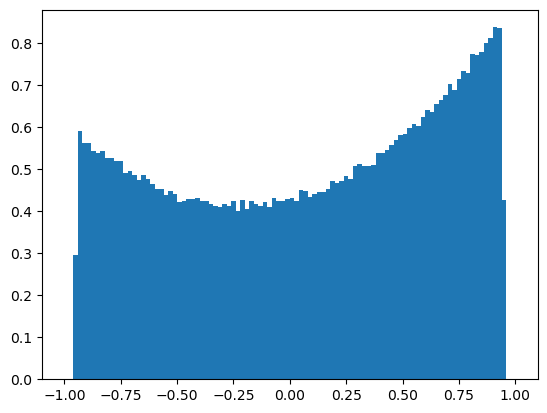

Media delle alpha stimate da MC = 0.332
Media delle beta stimate da MC = 0.809
Deviazione standard di alpha = 0.179
Deviazione standard di beta = 0.429


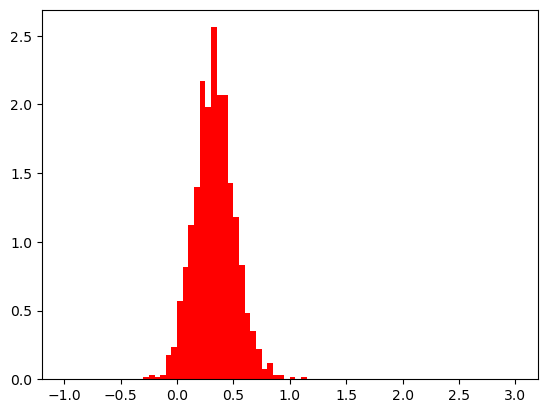

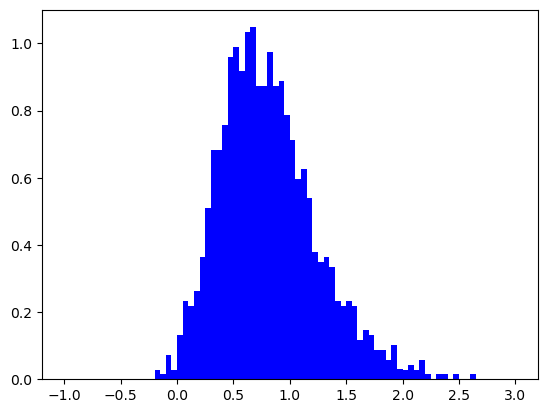

In [194]:
# ML + MC

# Ora che abbiamo la stima di alpha e beta calcoliamo la varianza con Montecarlo

# Per farlo ci generiamo N prove con nOss osservazioni
# Per ogni blocco di osservazioni ci stimiamo di nuovo alpha e beta, 
# come risultato avremo due array di stime di alpha e beta, 
# da questi due array ci calcoliamo la varianza, per farlo usiamo la formula della sample variance


# Numero di prove e osservazioni
N = 500000
nOss = 200

rand_x = np.random.uniform(xmin,xmax,N)

# mi calcolo la y dalla formula della funzione
y = f(rand_x,estimated_alpha,estimated_beta)
# Trovo la fmax guardando semplicemente i dati generati poi 
# ci aggiungo 0.1 per essere più sicuro di coprire tutto 
# lo spazio possibile della funzione e mi calcolo la y random
fmax = max(y)
rand_y = np.random.uniform(0,fmax+0.1,N)


accepted_x = []
count = 0

# hit or miss
for i in range(N):
  if(rand_y[i] < y[i]):
    accepted_x.append(rand_x[i])
    count = count + 1

plt.hist(accepted_x,100,(-1,1), density=True)
plt.show()


estimated_alpha_array_from_MC = []
estimated_beta_array_from_MC = []
# Suddivido le x accettate in varie osservazioni
# per ogni sample di osservazioni mi ricalcolo alpha e beta
for j in range(int(count/nOss)):
    # Eseguo l'ottimizzazione
    result = minimize(NegativeLogLikelihood, [0.0, 0.0],np.array((accepted_x[nOss*j:nOss*(j+1)])), method='Nelder-Mead')
    # Estraggo le stime di alpha e beta dal risultato
    estimated_alpha, estimated_beta = result.x
    # Aggiungo le stime all'array di stime
    estimated_alpha_array_from_MC.append(estimated_alpha)
    estimated_beta_array_from_MC.append(estimated_beta)


# Qui vado a fare la media di tutti i valori dell'array. 
# Quindi ricavo la media della stima delle alpha e delle beta.
mean_estimated_alpha = np.mean(estimated_alpha_array_from_MC)
mean_estimated_beta = np.mean(estimated_beta_array_from_MC)


# Qui ci calcoliamo la varianza con la formula della sample variance
# in questo pezzo facciamo la sommatoria delle xi con i che va da 1 a n, di (xi-media)^2
var_alpha = 0
var_beta = 0
for j in range(int(count/nOss)):
    var_alpha = var_alpha + (estimated_alpha_array_from_MC[j]-mean_estimated_alpha)**2
    var_beta = var_beta + (estimated_beta_array_from_MC[j]-mean_estimated_beta)**2


# qui facciamo il pezzo della formula 1/(n-1)
var_alpha = var_alpha/(int(count/nOss)-1)
var_beta = var_beta/(int(count/nOss)-1)


print(f"Media delle alpha stimate da MC = {mean_estimated_alpha:.3f}")
print(f"Media delle beta stimate da MC = {mean_estimated_beta:.3f}")
print(f"Deviazione standard di alpha = {np.sqrt(var_alpha):.3f}")
print(f"Deviazione standard di beta = {np.sqrt(var_beta):.3f}")
#print(np.mean(xxe))

plt.hist(estimated_alpha_array_from_MC,80,(-1,3), color = "red", density = True)
plt.show()
plt.hist(estimated_beta_array_from_MC,80,(-1,3), color = "blue", density = True)
plt.show()

In [195]:
# ML + RFC BOUND

# Qui faccio il calcolo analitico sfruttando l'RFC Bound facendo la derivata 
# seconda su alpha e beta, in questo modo trovo la varianza di ogni parametro

import sympy as sp


alpha,beta = sp.symbols('alpha beta')
# formula loglikelihood per sympy
def LogLikelihood_symbol(x,alpha,beta):
  result = 0
  for i in range(nOss):
    result += (sp.log(f(x[i],alpha,beta)))
  return result


log_likelihood = LogLikelihood_symbol(x_from_input,alpha,beta)

# Qui faccio la derivata della LogLikelihood rispetto ad alpha e beta
d_log_likelihood_alpha = sp.diff(log_likelihood, alpha)
d_log_likelihood_beta = sp.diff(log_likelihood,beta)

# Qui rifaccio la derivata della derivata precedente rispetto ad alpha e beta (quindi ora ho il calcolo delle derivate seconde)
d2_log_likelihood_alpha = sp.diff(d_log_likelihood_alpha, alpha)
d2_log_likelihood_beta = sp.diff(d_log_likelihood_beta,beta)

# Faccio la conversione in funzioni lambda per sympy
d2_log_likelihood_alpha_func = sp.lambdify((alpha,beta), d2_log_likelihood_alpha, 'numpy')
d2_log_likelihood_beta_func = sp.lambdify((alpha,beta), d2_log_likelihood_beta, 'numpy')

# Qui stampiamo varianze e deviazioni standard calcolandole dalla stima di alpha e beta fatta precedentemente con metodo ML
print(f"Varianza di alpha = ", 1/-(d2_log_likelihood_alpha_func(estimated_alpha,estimated_beta)))
print(f"Varianza di beta = ", 1/-(d2_log_likelihood_beta_func(estimated_alpha,estimated_beta)))

print(f"Deviazione standard di alpha = ", np.sqrt(1/-(d2_log_likelihood_alpha_func(estimated_alpha,estimated_beta))))
print(f"Deviazione standard di beta = ", np.sqrt(1/-(d2_log_likelihood_beta_func(estimated_alpha,estimated_beta))))


Varianza di alpha =  0.02130912365090607
Varianza di beta =  0.08994156841936576
Deviazione standard di alpha =  0.14597644895977593
Deviazione standard di beta =  0.29990259822043186
